In [61]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

In [62]:
f = uproot.open("/home/users/hdhoang2001/cmssw/src/RecoTracker/LSTCore/standalone/no_rz_cuts_md2.root:tree")

In [63]:
tree = f.arrays(["t3_residual", 
                 "t3_isFake", 
                 "t3_isPerfect", 
                 "t3_region", 
                 "t3_rzChiSquared", 
                 "t3_pt", 
                 "t3_eta", 
                 "t3_phi",
                 "t3_layer0",
                 "t3_layer1",
                 "t3_layer2",
                #  "t3_layer_binary",
                #  "t3_moduleType_binary"
                ], library="np")

In [64]:
res = np.abs(np.concatenate(tree["t3_residual"]))
isfake = np.concatenate(tree["t3_isFake"])
isperfect = np.concatenate(tree["t3_isPerfect"])
region = np.concatenate(tree["t3_region"])
rzchi2 = np.concatenate(tree["t3_rzChiSquared"])
pt = np.concatenate(tree["t3_pt"])
eta = np.concatenate(tree["t3_eta"])
phi = np.concatenate(tree["t3_phi"])
# layer_binary = np.concatenate(tree["t3_layer_binary"])
# moduleType_binary = np.concatenate(tree["t3_moduleType_binary"])
layer0 = np.concatenate(tree["t3_layer0"])
layer1 = np.concatenate(tree["t3_layer1"])
layer2 = np.concatenate(tree["t3_layer2"])

In [69]:
region_components = ["Endcap 1, 2, 3 ps",
                     "Endcap 1, 2 ps, 3 2s",
                     "Endcap 1 ps, 2, 3 2s",
                     "Endcap 2, 3, 4 ps",
                     "Endcap 2, 3 ps, 4 2s",
                     "Endcap 2 ps, 3, 4 2s",
                     "Endcap 3, 4, 5 ps",
                     "Endcap 3, 4 ps, 5 2s",
                     "Endcap 3 ps, 4, 5 2s",
                     "Barrel 1, Endcap 1, 2 ps",
                     "Barrel 1, 2, Endcap 1 ps",
                     "Barrel 1, 2, 3",
                     "Barrel 2, Endcap 1, 2 ps",
                     "Barrel 2, Endcap 1 ps, 2 2s",
                     "Barrel 2, 3, Endcap 1 ps",
                     "Barrel 2, 3, Endcap 1 2s",
                     "Barrel 2, 3, 4",
                     "Barrel 3, Endcap 1, 2 ps",
                     "Barrel 3, Endcap 1 ps, 2 2s",
                     "Barrel 3, Endcap 1, 2 2s",
                     "Barrel 3, 4, 5",
                     "Barrel 3, 4, Endcap 1 2s",
                     "Barrel 4, Endcap 1, 2 ps",
                     "Barrel 4, 5, 6",
                     "Barrel 4, 5, Endcap 1 2s",
                     "Barrel 5, Endcap 1, 2 2s"]

In [70]:
def plot_hist(fake, real_75_99, real_100, xlabel, min=0, max=250, cut=0, save_file=None, output_stats=False, title=None, log=False):
    fig = plt.figure(figsize=(6, 4))
    histogram = fig.add_subplot(111)
    bins = np.linspace(min, max, 100)
    sorted_real_100 = np.sort(np.abs(real_100))
    
    loose_cut = 0
    tight_cut = 0
    fake_remained_loose = 0
    fake_remained_tight = 0
    
    if output_stats:
        if len(sorted_real_100) != 0:
            loose_cut = sorted_real_100[int(len(sorted_real_100)*0.99)]
            tight_cut = sorted_real_100[int(len(sorted_real_100)*0.95)]
            fake_remained_loose = len(fake[fake<loose_cut]) / len(fake) * 100
            fake_remained_tight = len(fake[fake<tight_cut]) / len(fake) * 100
    else:
        loose_cut = 0
        tight_cut = 0
    if cut != 0:
        histogram.hist(np.clip(fake[fake<cut], bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="fake match (yield: {})".format(len(fake[fake<cut])))
        histogram.hist(np.clip(real_75_99[real_75_99<cut], bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="75-99% match (yield: {})".format(len(real_75_99[real_75_99<cut])))
        histogram.hist(np.clip(real_100[real_100<cut], bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="100% match (yield: {})".format(len(real_100[real_100<cut])))
    else:
        histogram.hist(np.clip(fake, bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="<75% match (yield: {})".format(len(fake)))
        histogram.hist(np.clip(real_75_99, bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="75-99% match (yield: {})".format(len(real_75_99)))
        histogram.hist(np.clip(real_100, bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="100% match (yield: {})".format(len(real_100)))
        
    if output_stats:
        cell_text = [["cut value", loose_cut, tight_cut],
                     ["true (100% match) remained", "99%", "95%"],
                     ["fake (<75% match) remained", "{:.2f}%".format(fake_remained_loose), "{:.2f}%".format(fake_remained_tight)]]
        histogram.table(cell_text, bbox=[0, -0.4, 1, 0.2], cellLoc="center")
    
    if title:
        histogram.set_title(title)
    
    histogram.legend()
    histogram.set_xlabel(xlabel)
    histogram.set_ylabel("yield")
    histogram.set_xlim(left=min)
    
    if log:
        histogram.set_yscale("log")
    if save_file:
        if output_stats:
            fig.savefig(save_file, bbox_inches="tight")
        else:
            fig.savefig(save_file)
    return loose_cut, tight_cut


In [71]:
res_fake = res[isfake==1]
res_75_99 = res[((1-isfake) & (1-isperfect))==1]
res_100 = res[isperfect==1]

In [72]:
res_by_region = [res[region==i] for i in range(26)]
isfake_by_region = [isfake[region==i] for i in range(26)]
isperfect_by_region = [isperfect[region==i] for i in range(26)]

In [73]:
res_fake_by_region = [res_by_region[i][isfake_by_region[i]==1] for i in range(26)]
res_75_99_by_region = [res_by_region[i][((1-isfake_by_region[i]) & (1-isperfect_by_region[i]))==1] for i in range(26)]
res_100_by_region = [res_by_region[i][isperfect_by_region[i]==1] for i in range(26)]

In [83]:
rzchi2_by_region = [rzchi2[(region==i) & (rzchi2>=0)] for i in range(26)]
pt_by_region = [pt[(region==i) & (rzchi2>=0)] for i in range(26)]
eta_by_region = [eta[(region==i) & (rzchi2>=0)] for i in range(26)]

In [84]:
isfake_by_region = [isfake[(region==i) & (rzchi2>=0)] for i in range(26)]
isperfect_by_region = [isperfect[(region==i) & (rzchi2>=0)] for i in range(26)]

In [85]:
rzchi2_fake_by_region = [rzchi2_by_region[i][(isfake_by_region[i]==1)] for i in range(26)]
rzchi2_75_99_by_region = [rzchi2_by_region[i][((1-isfake_by_region[i]) & (1-isperfect_by_region[i]))==1] for i in range(26)]
rzchi2_100_by_region = [rzchi2_by_region[i][isperfect_by_region[i]==1] for i in range(26)]

In [86]:
loose_cuts = []
tight_cuts = []
for i in range(26):
    loose_cut, tight_cut = plot_hist(rzchi2_fake_by_region[i], 
              rzchi2_75_99_by_region[i], 
              rzchi2_100_by_region[i], 
              xlabel="t3 r-z chi2", 
              save_file=f"t3_rzchi2_md2_by_region/region_{i}.png",
              output_stats=True,
              title=f"Region {i} (" + region_components[i] + ")")
    loose_cuts.append(loose_cut)
    tight_cuts.append(tight_cut)
    plt.close()

In [87]:
loose_cuts = []
tight_cuts = []
for i in range(26):
    loose_cut, tight_cut = plot_hist(rzchi2_fake_by_region[i], 
              rzchi2_75_99_by_region[i], 
              rzchi2_100_by_region[i], 
              xlabel="t3 r-z chi2", 
              save_file=f"t3_rzchi2_md2_by_region_log/region_{i}.png",
              output_stats=True,
              log=True,
              title=f"Region {i} (" + region_components[i] + ")")
    loose_cuts.append(loose_cut)
    tight_cuts.append(tight_cut)
    plt.close()

In [88]:
rzchi2_high_pt_nan = np.abs(rzchi2[rzchi2 < 0])
isfake_high_pt_nan = isfake[rzchi2 < 0]
isperfect_high_pt_nan = isperfect[rzchi2 < 0]

(2.7711823, 2.3840034)

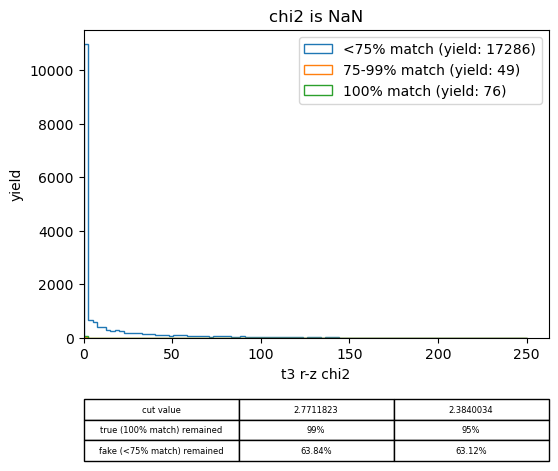

In [89]:
plot_hist(rzchi2_high_pt_nan[isfake_high_pt_nan==1],
          rzchi2_high_pt_nan[((1-isfake_high_pt_nan) & (1-isperfect_high_pt_nan))==1],
          rzchi2_high_pt_nan[isperfect_high_pt_nan==1],
          xlabel="t3 r-z chi2",
          save_file="t3_rzchi2_md2_by_region/t3_rzchi2_high_pt_nan.png",
          title="chi2 is NaN",
          output_stats=True,
          min=0, max=250)

(2.7711823, 2.3840034)

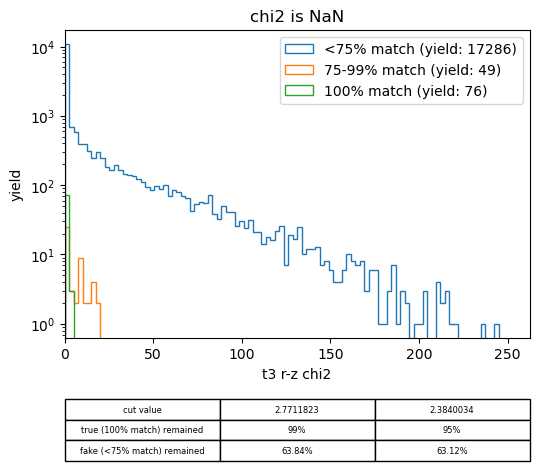

In [90]:
plot_hist(rzchi2_high_pt_nan[isfake_high_pt_nan==1],
          rzchi2_high_pt_nan[((1-isfake_high_pt_nan) & (1-isperfect_high_pt_nan))==1],
          rzchi2_high_pt_nan[isperfect_high_pt_nan==1],
          xlabel="t3 r-z chi2",
          save_file="t3_rzchi2_md2_by_region_log/t3_rzchi2_high_pt_nan.png",
          title="chi2 is NaN",
          output_stats=True,
          log=True,
          min=0, max=250)